# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import helper_functions as hf
import matplotlib.pyplot as plt
import itertools
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
data_wide = pd.read_csv('./zillow_data.csv')

In [3]:
data_wide.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
data_long = hf.melt_data_v2(data_wide)
data_long['time'] = pd.to_datetime(data_long['time'], format='%Y-%m-%d')
data_long['RegionName'] = data_long['RegionName'].astype('str')

data_long.set_index(keys='time', inplace=True)
data_long.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0


In this project, we will be looing at zip codes in Florida, specifically areas near Orlando

In [5]:
#separate out areas within the state of Florida
df_fl = data_long.loc[data_long.State=='FL']
df_fl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205265 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
RegionID      205265 non-null int64
RegionName    205265 non-null object
City          205265 non-null object
State         205265 non-null object
Metro         198110 non-null object
CountyName    205265 non-null object
SizeRank      205265 non-null int64
value         205265 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 14.1+ MB


In [6]:
df_fl.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         7155
CountyName       0
SizeRank         0
value            0
dtype: int64

In [7]:
df_fl.info()
df_fl.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205265 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
RegionID      205265 non-null int64
RegionName    205265 non-null object
City          205265 non-null object
State         205265 non-null object
Metro         198110 non-null object
CountyName    205265 non-null object
SizeRank      205265 non-null int64
value         205265 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 14.1+ MB


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0
1996-04-01,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0
1996-04-01,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0
1996-04-01,72578,33411,Royal Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,84,126800.0
1996-04-01,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0


# Step 2: Data Preprocessing

# Step 3: EDA and Visualization

In [8]:
from matplotlib import rc

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [9]:
# In the state array, there are 51 entries.
data_long.State.unique().shape

(51,)

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


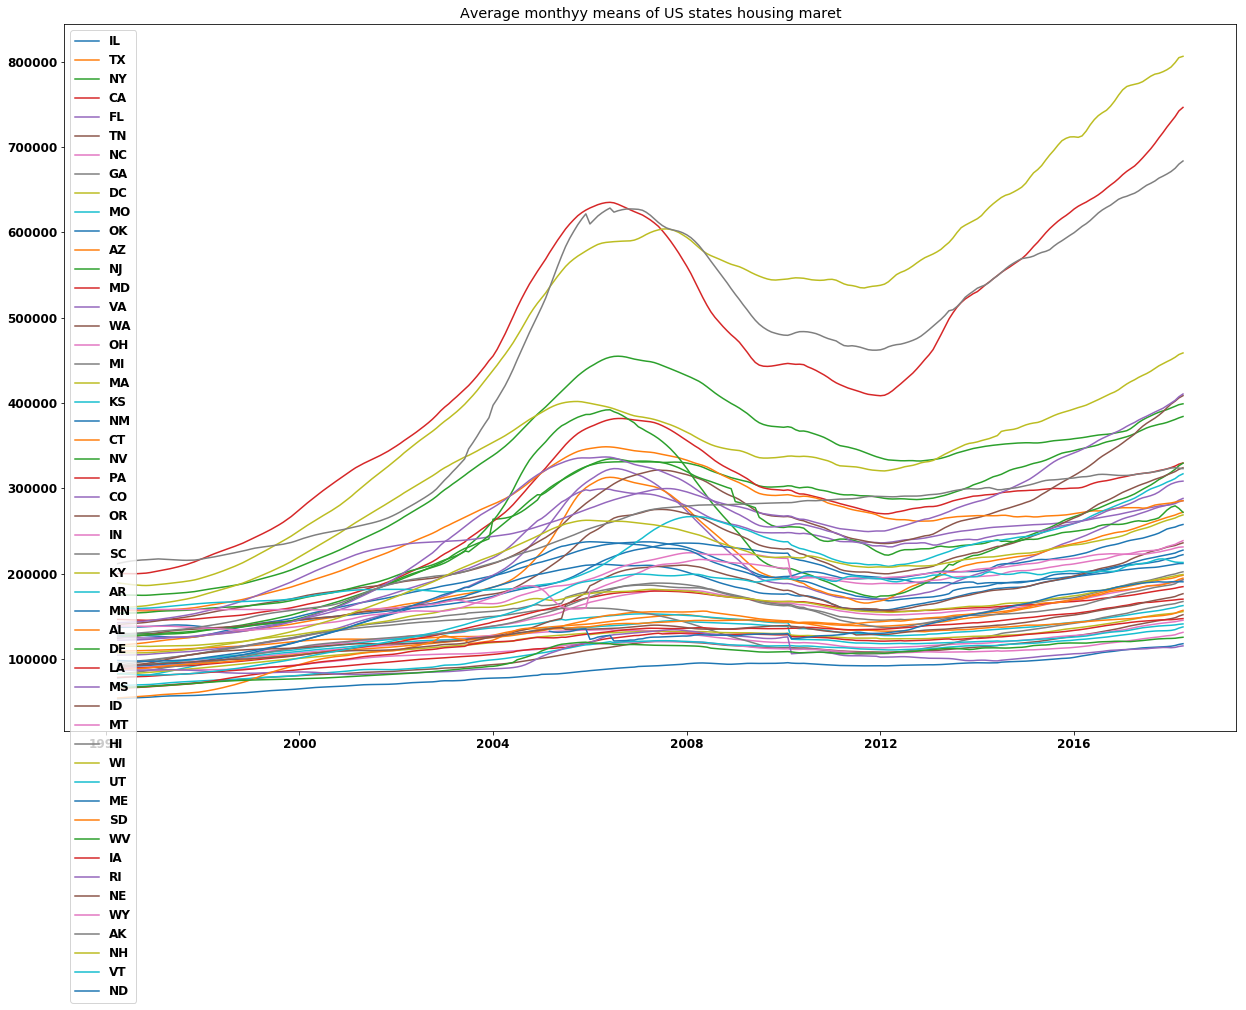

In [10]:
#Looking at each state to see averages over the years
plt.figure(figsize=(21,13))
for state in data_long.State.unique():
    state_data = data_long.loc[(data_long.State==state), ['value']].resample('MS').mean()
    plt.plot(state_data, label=state)
    
plt.title('Average monthyy means of US states housing maret')
plt.legend()
plt.show()

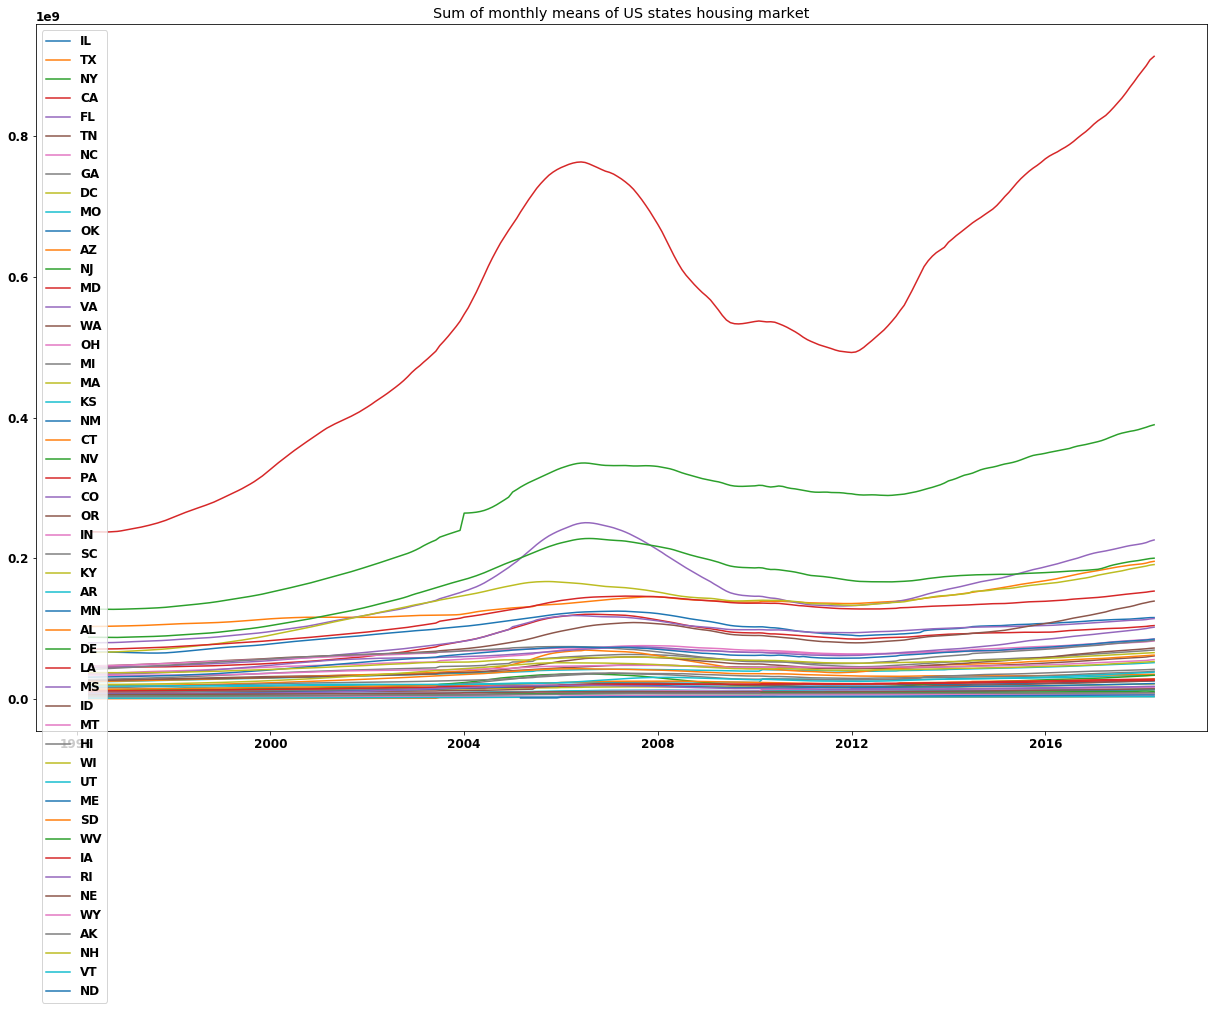

In [11]:
#Looking at each state to see the total means over the years
plt.figure(figsize=(21,13))
for state in data_long.State.unique():
    state_data = data_long.loc[(data_long.State==state), ['value']].resample('MS').sum()
    plt.plot(state_data, label=state)
    
plt.title('Sum of monthly means of US states housing market')
plt.legend()
plt.show()

In [12]:
df_fl.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0
1996-04-01,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0
1996-04-01,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0
1996-04-01,72578,33411,Royal Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,84,126800.0
1996-04-01,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0


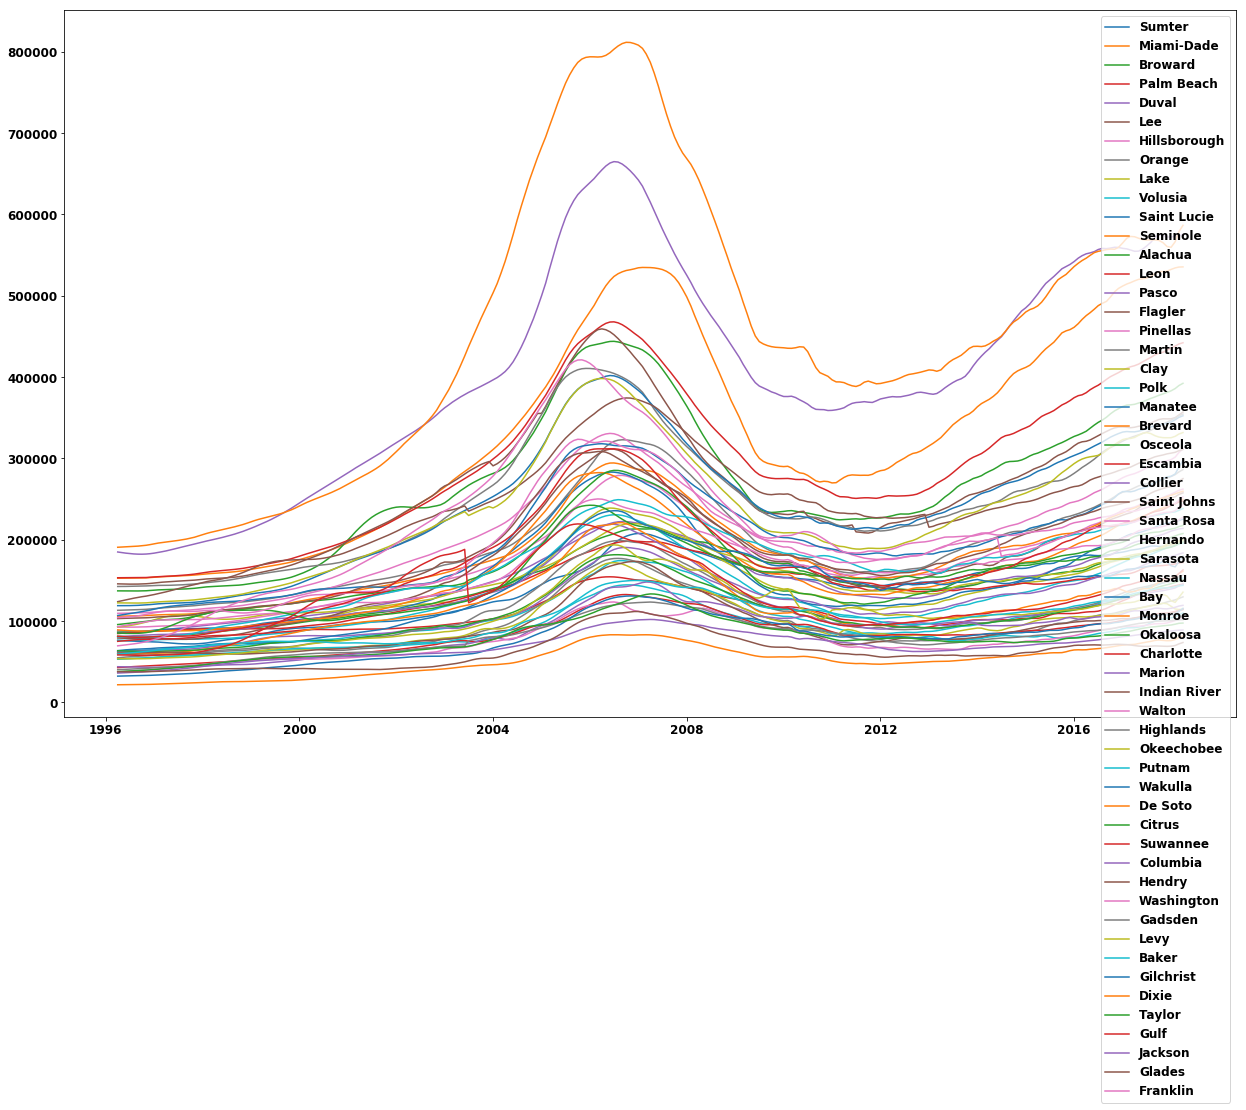

In [13]:
# loop to print out the counties for the state of Florida
plt.figure(figsize=(21,13))
for county in df_fl.CountyName.unique():
    county_data = df_fl.loc[(df_fl.CountyName==county), ['value']].resample('MS').mean()
    plt.plot(county_data, label=county)
plt.legend()
plt.show()

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


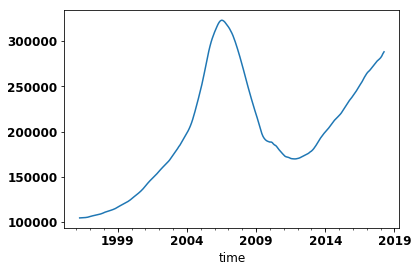

In [14]:
# Florida monthly means ovre the years
florida_monthly = df_fl.groupby(pd.Grouper(freq='MS'))
florida_monthly.value.mean().plot()

In [29]:
## Separate out Florida by year 2011
df_fl_2011 = df_fl['2011':]
# df_fl_2011.loc[(df_fl.CountyName=='Orange'), ['value']].resample('MS').mean()
df_fl_2011.loc[(df_fl_2011.CountyName=='Orange'), ['value']].resample('MS').mean()

,value
time,
2011-01-01,165019.444444
2011-02-01,162794.444444
2011-03-01,160980.555556
2011-04-01,160016.666667
2011-05-01,159455.555556
2011-06-01,159119.444444
2011-07-01,159497.222222
2011-08-01,160261.111111
2011-09-01,160766.666667


No handles with labels found to put in legend.


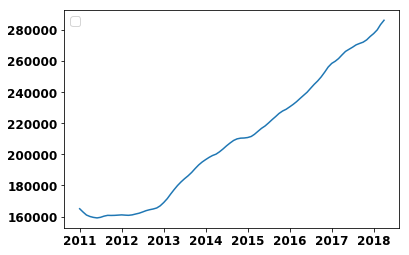

In [30]:
# Separate out the areas that are part of Orange County, Florida BY YEAR 2011
orange_county = df_fl_2011.loc[(df_fl_2011.CountyName=='Orange'), ['value']].resample('MS').mean()
plt.plot(orange_county)
plt.legend()
plt.show()

# df_fl_2011.loc[(df_fl_2011.CountyName=='Orange'), ['value']].resample('MS').mean()

In [31]:
# Separate out the areas that are part of Orange County, Florida
# orange_county = df_fl.loc[(df_fl.CountyName=='Orange'), ['value']].resample('MS').mean()
# plt.plot(orange_county)
# plt.legend()
# plt.show()

Based on our graph below, there appears to be some seasonality that is occurring within the housing market for orange county as time passes by.

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


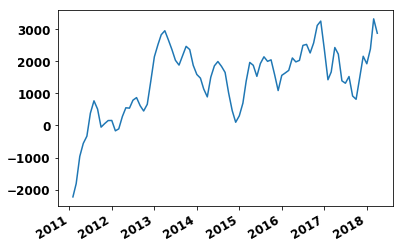

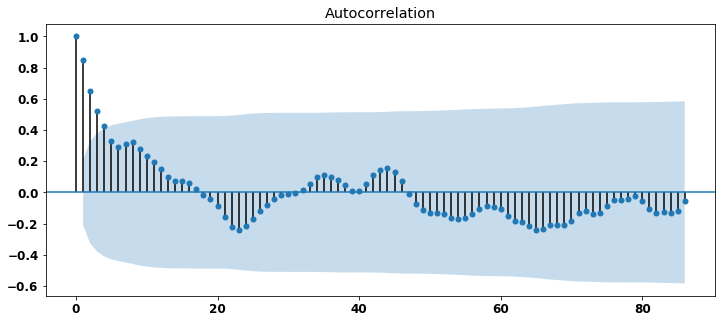

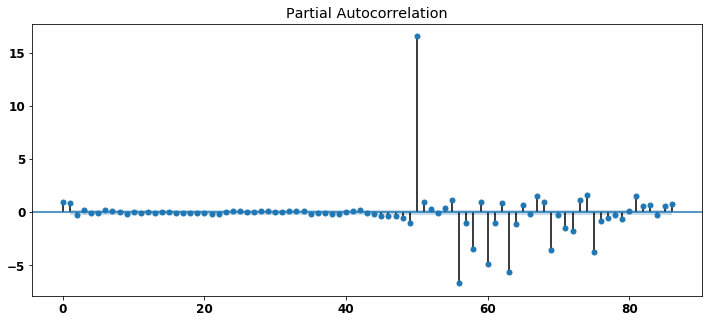

In [32]:
## Looking at difference by year
# Look at the distribution of the diffs and look at the one with the smallest standard deviation
orange_county_diff = orange_county.diff(periods=1)
plt.plot(orange_county_diff)

plt.gcf().autofmt_xdate()
rcParams['figure.figsize'] = (12, 5)

plot_acf(orange_county_diff.dropna());
plot_pacf(orange_county_diff.dropna());

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


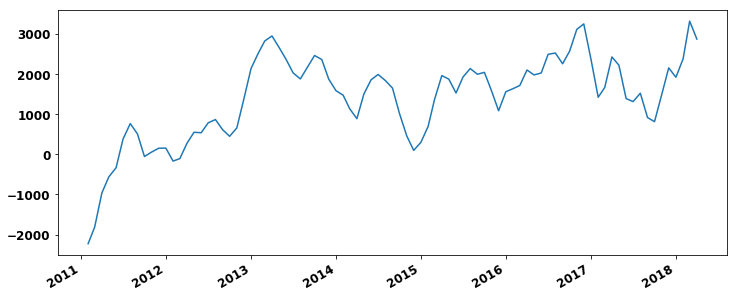

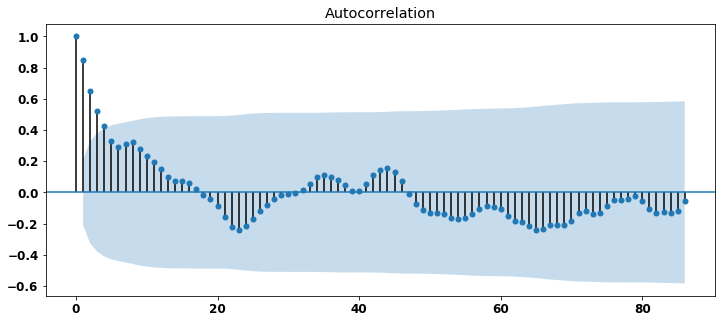

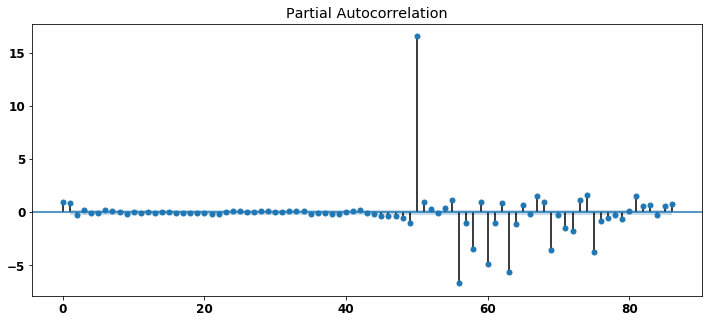

In [33]:
## Looking at difference by year
# Look at the distribution of the diffs and look at the one with the smallest standard deviation
orange_county_diff = orange_county.diff(periods=1)
plt.plot(orange_county_diff)

plt.gcf().autofmt_xdate()
rcParams['figure.figsize'] = (12, 5)

plot_acf(orange_county_diff.dropna());
plot_pacf(orange_county_diff.dropna());

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


<Figure size 864x360 with 0 Axes>

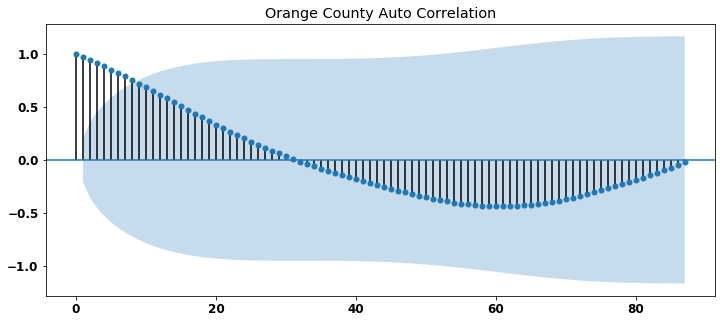

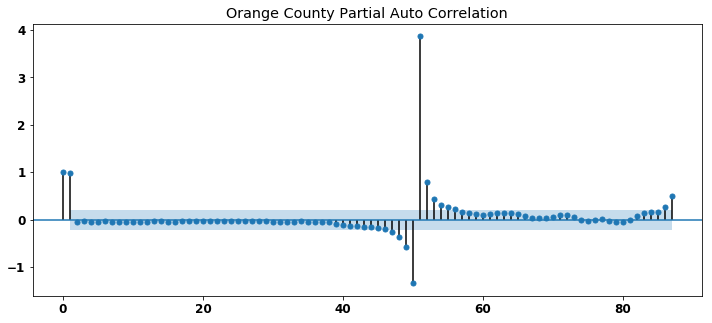

In [34]:
## Using ACF & PACF to view differencing for time series##

plt.gcf().autofmt_xdate()
rcParams['figure.figsize'] = (12, 5)

plot_acf(orange_county, title='Orange County Auto Correlation');
plot_pacf(orange_county, title='Orange County Partial Auto Correlation');

Based on what we see in our partial correlation plot, there is a high negative correlation somewhere between 220 - 245 lags.

This high negative appears at lag = 180 months

In [35]:
# orange_county_diff = orange_county.diff(periods=180)

# plot_acf(orange_county, lags=181);
# plot_pacf(orange_county, lags=181);

### Seasonal Decomposition

In [ ]:
data.head()

seasonal_decompose()

# trend = 
# seasonal = 
# residual = 

# Step 4: Reshape from Wide to Long Format

In [36]:
orange_county

,value
time,
2011-01-01,165019.444444
2011-02-01,162794.444444
2011-03-01,160980.555556
2011-04-01,160016.666667
2011-05-01,159455.555556
2011-06-01,159119.444444
2011-07-01,159497.222222
2011-08-01,160261.111111
2011-09-01,160766.666667


# Step 5: ARIMA Modeling

In [37]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in pdq]

In [38]:
## NEED TO TURN THIS INTO A FUNCTION THAT I CAN PASS
## EACH ZIP CODE INTO AS A DATAFRAME, 
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(orange_county,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            output = mod.fit()
            ans.append([comb, combs, output.aic, output.bic])
            print('ARIMA {} x {}12 : AIC Calculated ={}, BIC Calculated ={}'.format(comb, combs, output.aic, output.bic))
        except:
            continue

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =2384.1005668718512, BIC Calculated =2386.566474990506
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =2021.1536690155535, BIC Calculated =2025.7886452426262
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1700.3381567520937, BIC Calculated =1702.65564486563
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1440.286450085454, BIC Calculated =1444.572719538237
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1567.0508874939978, BIC Calculated =1571.7123541745705
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1486.822013672228, BIC Calculated =1493.7744780128369
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1370.2947496815136, BIC Calculated =1374.612515848233
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1296.1146328057876, BIC Calculated =1302.544036984962
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =2297.663796043999, BIC Calculated =2302.572490636506
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calcula

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1082.791308985678, BIC Calculated =1089.2207131648524
ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1289.953536866804, BIC Calculated =1296.9060012074128
ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1215.958623969765, BIC Calculated =1225.2285764239102
ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1078.4950000640777, BIC Calculated =1084.9244042432522


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1085.7077816321266, BIC Calculated =1094.2803205376927
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =1335.0086095856423, BIC Calculated =1342.3716514744028
ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =1139.149705277434, BIC Calculated =1148.3659656502505
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =1245.738628741014, BIC Calculated =1252.6508240206265


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =989.9256992058889, BIC Calculated =998.4342367460692
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =1150.9838987681262, BIC Calculated =1160.2538512222714
ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =1136.6540775203464, BIC Calculated =1148.1744029863673
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =1017.3968228167948, BIC Calculated =1025.9693617223609
ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =999.3106409149348, BIC Calculated =1009.9463128401602
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =1285.6403424325772, BIC Calculated =1290.5490370250843
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =1107.1150195546502, BIC Calculated =1114.0272148342626
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =1150.8067520095742, BIC Calculated =1155.4148821959825
ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =962.234344440848, BIC Calculated =968.6157475959833
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Cal

In [39]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic', 'bic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           917.649
bic           928.204
Name: 63, dtype: object

In [40]:
ans_df.loc[ans_df['bic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           917.649
bic           928.204
Name: 63, dtype: object

Now that we have the results from our SARIMA model, we will now take the results with best AIC and BIC and pass it into our Model to see how ti performed compared to the others

Fitting ARIMA Time Series Model 

In [41]:
def model_SARIMA(df=None, order=None, s_order=None):
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df,
                                    order=order,
                                    seasonal_order=s_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    output = ARIMA_MODEL.fit()
    print(output.summary().tables[1])
    output.plot_diagnostics(figsize=(15, 18))
    plt.show()

In [42]:
## Results stored within our answer dataframe ##
ans_df

,pdq,pdqs,aic,bic
0,"(0, 0, 0)","(0, 0, 0, 12)",2384.100567,2386.566475
1,"(0, 0, 0)","(0, 0, 1, 12)",2021.153669,2025.788645
2,"(0, 0, 0)","(0, 1, 0, 12)",1700.338157,1702.655645
3,"(0, 0, 0)","(0, 1, 1, 12)",1440.286450,1444.572720
4,"(0, 0, 0)","(1, 0, 0, 12)",1567.050887,1571.712354
5,"(0, 0, 0)","(1, 0, 1, 12)",1486.822014,1493.774478
6,"(0, 0, 0)","(1, 1, 0, 12)",1370.294750,1374.612516
7,"(0, 0, 0)","(1, 1, 1, 12)",1296.114633,1302.544037
8,"(0, 0, 1)","(0, 0, 0, 12)",2297.663796,2302.572491
9,"(0, 0, 1)","(0, 0, 1, 12)",1967.130497,1974.042693


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7229      0.094      7.689      0.000       0.539       0.907
ma.L1          0.7652      0.110      6.979      0.000       0.550       0.980
ar.S.L12       0.0177      0.012      1.445      0.148      -0.006       0.042
ma.S.L12      -0.2354      0.095     -2.487      0.013      -0.421      -0.050
sigma2      1.914e+05   4.26e+04      4.489      0.000    1.08e+05    2.75e+05


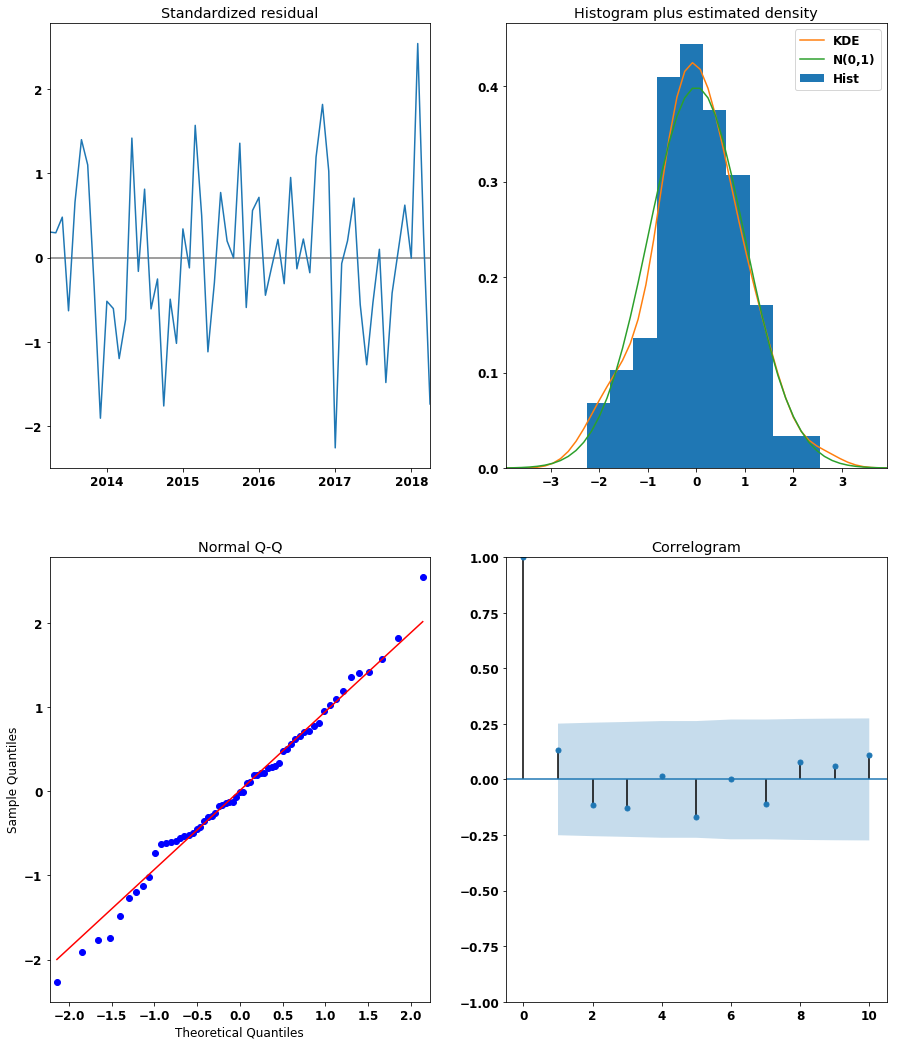

In [43]:
order = ans_df.loc[ans_df['aic'].idxmin()]['pdq']
s_order = ans_df.loc[ans_df['aic'].idxmin()]['pdqs']
model_SARIMA(df=orange_county, order=order, s_order=s_order)

Based on the results of the plot diagnostics, we see that our data is not normally distributed. From here, we will continue to further look into our model and attempt to improve the results by removing outliers and the residuals that are causing issues within our model.

# Step 6: Interpreting Results